In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cProfile

In [ ]:
import pyomo.environ as pyo
from models.mp_controller.forcasting import ForcastingProto
from models.mp_controller.opt_models.MILP_model_proto import MILPModelProto
from pyomo.contrib.appsi.solvers.highs import Highs
from collections import defaultdict

class MPController_v2():
    def __init__(self, name, n_periods, delta_t, pyo_solver_name='appsi_highs', sep='.'):
        '''A model predicteve Controller utilizing MILP with pyomo. 
        MILP Models can be added to the model via the add_model() method. Added models need to follow a given structure. 
        Please find examples for reference.
        Inputs and outputs get configured automatically based on the added models.
        
        Parameters
        ----------
        n_periods : int, length of optimization horizon
        delta_t : int, timedelta of the controller in s
        pyo_solver_name : str, name of a pyomo solver (passed to pyo.SolverFactory)
        return_forcast : bool, return the forcast values as outputs of the controller model
        '''
        self.name       = name
        self.n_periods  = n_periods
        self.delta_t    = delta_t
        self.inputs = []
        self.outputs = []
        
        self.shared_vars = set()

        self.sep = sep

        # self.return_forcast = return_forcast

        self.solver = Highs() # pyo.SolverFactory(pyo_solver_name)

        # make Energy Community model
        self.model      = pyo.ConcreteModel()

        self.model.timepoints = pyo.RangeSet(0, n_periods) # Range of timepoints
        self.model.periods    = pyo.RangeSet(0, n_periods-1) # Range of periods
        self.model.delta_t    = pyo.Param(initialize=delta_t) # s

        self.components = [] # list of components that get added via add_model (they need to follow a specific syntax! see examples)
        self.forcasters = [] # list of forcasters that get added via add_model (they need to follow a specific syntax! see examples)    

    def add_model(self, component:MILPModelProto):
        '''add a model which needs to follow the given structure, see the examples'''
        # add components to the list of components
        self.components += [component]
        # Add constraints as a block to the EC model:
        self.model.add_component(component.name, pyo.Block(rule=component.pyo_block_rule))
        comp = self.model.find_component(component.name)

        # append model inputs and outputs
        self.inputs += [component.name+self.sep+i for i in component.inputs]
        self.outputs += [component.name+self.sep+o for o in component.outputs]
        self.outputs += [component.name+self.sep+o for o in component.control_outputs]

        for shared in component.shares:
            if shared not in self.shared_vars:
                # Add expression and Constraint for shared variable to the model
                self.shared_vars.add(shared)
                self.model.add_component('sum_expr_'+shared, pyo.Expression(self.model.periods, rule=0))
                rule = lambda m, p: m.find_component('sum_expr_'+shared)[p] == 0
                self.model.add_component('sum_constraint_'+shared, 
                                         pyo.Constraint(self.model.periods, rule=rule))
                
            # Add the shared variable to the corresponding Expression
            comp = self.model.find_component(component.name)
            shared_attr = comp.find_component(shared)
            if shared_attr.index_set().name != 'periods':
                raise ValueError("All shared values need to be indexed by 'model.periods'")
            for p in self.model.periods:
                self.model.find_component('sum_expr_'+shared)[p] += shared_attr[p]

    def add_forcaster(self, forcaster:ForcastingProto, for_model:MILPModelProto, for_var:str):
        '''Adds a forcasting object to the controller for a model input of the MILP model
        Parameters
        ----------
        forcaster :  Forcast, forcsting object for a variable 
        for_model : MILP_Model, the model that the forcast is for
        for_vars : str, the forcast_inputs attribute of for_model to connect the forcast to'''
        if for_model not in self.components:
            raise ValueError(f'Model "{for_model.name}" needs to be added to the controller before the forcaster can be assigned')
        if for_var not in for_model.inputs: 
            raise AttributeError(f'Model {for_model} has no input {for_var}')
        
        # forecaster name prefix
        pre = for_model.name + self.sep + 'forecast' + self.sep
        complete_for_var = pre+for_var

        # add forecast inputs to general inputs
        for inp in forcaster.inputs:
            self.inputs += [pre+inp]
        
        # self.forcasters += [(pre, for_var, forcaster)]
        self.forcasters += [(pre, for_model, for_var, forcaster)]

        forcaster.set_forcast_length(self.n_periods)
        if hasattr(forcaster, 'set_delta_t'):
            forcaster.set_delta_t(self.delta_t)

        # # modify outputs
        # if self.return_forcast:
        #     self.outputs += [complete_for_var]

    def step(self, time, **inputs):      
        # update forecasters with input data
        for pre, for_model, for_var, forecaster in self.forcasters:
            # map inputs for forcasters
            forc_inputs = {inp: inputs[pre+inp] for inp in forecaster.inputs}
            forecaster.set_data(time, **forc_inputs)

        # collect all data for the components form the inputs
        all_comp_inputs = defaultdict(dict)
        for comp_attr_name, value in inputs.items():
            comp_name, attr_name = comp_attr_name.split(self.sep, maxsplit=1)
            all_comp_inputs[comp_name][attr_name] = value

        # create forecasts and collect for each component
        for pre, for_model, for_var, forecaster in self.forcasters:
            all_comp_inputs[for_model.name][for_var] = forecaster.get_forcast(time)
        
        # execute pre and collect pre outputs
        for comp in self.components:
            if hasattr(comp, 'pre'):
                pre_output = comp.pre(**all_comp_inputs[comp.name])
                all_comp_inputs[comp.name].update(pre_output)

        # Initialize parameters of the optimization model
        for comp in self.components:
            opt_comp = self.model.find_component(comp.name)
            comp_inputs = all_comp_inputs[comp.name]
            for attr_name, value in comp_inputs.items():
                opt_attr = opt_comp.find_component(attr_name)
                if len(opt_attr.index_set()) > 1:
                    if len(opt_attr.index_set()) != len(value):
                        raise ValueError(f'Missmatch in length when setting data for attribute {attr_name} of component {comp.name}')
                    for i in opt_attr.index_set():
                        opt_attr[i] = value[i]
                else:
                    opt_attr[None] = value # Weird syntax from pyomo!

        # Solve Model
        self.model.pprint()
        solver_outpt = self.solver.solve(self.model)#, tee=True)

        # get outputs from models
        outputs = {}
        for comp in self.components:
            pyo_comp = self.model.find_component(comp.name)
            # collect controll outputs from model
            for out_name in comp.control_outputs:
                out_attr = pyo_comp.find_component(out_name)
                outputs[comp.name+self.sep+out_name] = pyo.value(out_attr[0])
            # collect other outputs from model
            for out_name in comp.outputs:
                out_attr = pyo_comp.find_component(out_name)
                index = out_attr.index_set()
                if len(index) > 0:
                    out_value = [pyo.value(out_attr[i]) for i in index]
                else:
                    out_value = pyo.value(out_attr)
                outputs[comp.name+self.sep+out_name+'_out'] = out_value
                
        # if self.return_inputs:
        #     for comp_name, attrs in all_comp_inputs.items():
        #         for attr, value in attrs.items():
        #             outputs[comp_name+self.sep+attr] = value

        return outputs

In [3]:
class BES_MILP_model():
    def __init__(self, name, E_min=0., E_max=20_000.*3600, P_max_cha=20_000., P_max_dis=20_000., eta_cha=0.95, eta_dis=0.95):
        '''
        A battery energy storag model with charging and discharging efficiencies.
        The model needs to be used in an parent model to function correctly!
        The parent pyomo model is required to have the following attributes:
        - model.timepoints : pyo.RangeSet, timepoints of the simulation
        - model.periods : pyo.RangeSet, eriods of the simulation
        - model.delta_t : pyo.Param, timedelta of the simulation
        
        Parameter:
        ---------
        E_min : float, minimum energy of the storage in J
        E_max : float, maximum energy of the storage in J
        P_max_cha : maximum charging power in W
        P_max_dis : maximum discharging powre in W
        eta_cha : float [0, 1] charging efficiency (no unit)
        eta_dis : float [0, 1] discharging efficiency (no unit)'''

        # Parameters
        self.name      = name
        self.E_min     = E_min # J
        self.E_max     = E_max # 20 kWh in J
        self.P_max_cha = P_max_cha # W
        self.P_max_dis = P_max_dis # W
        self.eta_cha   = eta_cha # 1
        self.eta_dis   = eta_dis # 1

        # config info
        self.state_inputs     = ['E_BES_0'] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.inputs     = ['E_BES_0'] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.outputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.states           = ['E']
        self.forcast_inputs   = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.control_outputs = ['P_el'] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = ['P_el'] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods

    def pyo_block_rule(self, block):
        model = block.model()

        # Inputs
        block.E_BES_0   = pyo.Param(mutable=True, domain=pyo.NonNegativeReals, validate=lambda _, E: self.E_min <= E and E <= self.E_max) # J

        # Variables / Outputs
        block.E         = pyo.Var(model.timepoints, domain=pyo.NonNegativeReals, bounds=(self.E_min, self.E_max)) # J
        block.P_el      = pyo.Var(model.periods, domain=pyo.Reals) # Electrical Power in W (feed in = positive, consumption = negative)

        # helper Variables
        block.P_el_cha  = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Electrical charging Power in W (helper)
        block.P_el_dis  = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Electrical discharging Power in W (helper)
        block.bool      = pyo.Var(model.periods, domain=pyo.Boolean) # prevent same time charging and discharging

        @block.Constraint(model.periods)
        def energy_balance(block, p):
            return block.E[p+1] == block.E[p] + (block.P_el_cha[p] * self.eta_cha - block.P_el_dis[p] / self.eta_dis) * model.delta_t
        
        @block.Constraint(model.periods)
        def output_power(block, p):
            return block.P_el[p] == block.P_el_cha[p] - block.P_el_dis[p]

        @block.Constraint(model.periods)
        def power_limit_bool_cha(block, p):
            return block.P_el_cha[p] <= block.bool[p] * self.P_max_cha
        
        @block.Constraint(model.periods)
        def power_limit_bool_dis(block, p):
            return block.P_el_dis[p] <= block.bool[p] * self.P_max_dis

        @block.Constraint()
        def initial_condition(block):
            return block.E[0] == block.E_BES_0

In [ ]:
import pyomo.environ as pyo

class EC__Residual_Load_MILP_model(): 
    def __init__(self, name='EC'):
        '''
        An Energy Community MILP Model.
        The parent pyomo model is required to have the following attributes:
        - model.timepoints : pyo.RangeSet, timepoints of the simulation
        - model.periods : pyo.RangeSet, eriods of the simulation
        - model.delta_t : pyo.Param, timedelta of the simulation
        
        Parameter:
        ---------
        name : str, name of the Energy Community model'''

        # Parameters
        self.name      = name

        # config info
        self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.inputs     = ['P_resid_ec'] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.outputs    = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.forcast_inputs   = ['P_resid_ec'] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.control_outputs = [] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = ['P_el'] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods

    def pyo_block_rule(self, block):
        model = block.model()
        block.P_el       = pyo.Var(model.periods, domain=pyo.Reals) # Electrical Power in W (feed in = positive, consumption = negative)
        block.P_resid_ec = pyo.Param(model.periods, mutable=True, domain=pyo.Reals) # Residual load of EC (surplus_load > 0 > surplus_generation)

        # EC / Grid constraints:
        @block.Constraint(model.periods)
        def grid_constraint(b, p):
            return (b.P_el[p] == b.P_resid_ec[p]) 

In [ ]:
import pyomo.environ as pyo
from typing import Literal

class Objective(): 
    def __init__(self, name='EC', objective=Literal['self-consumption', 'self-consumption-slack', 'peak-power']):
        '''
        Objective function.
        The parent pyomo model is required to have the following attributes:
        - model.timepoints : pyo.RangeSet, timepoints of the simulation
        - model.periods : pyo.RangeSet, eriods of the simulation
        - model.delta_t : pyo.Param, timedelta of the simulation
        
        Parameter:
        ---------
        name : str, name of the objective
        objective : Literal, objective function'''

        # Parameters
        self.name      = name

        # config info
        self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.inputs           = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.forcast_inputs   = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.control_outputs  = ['P_el'] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.outputs          = ['P_el'] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = ['P_el'] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods

        match objective:
            case 'self-consumption':
                self.pyo_block_rule = self._self_consumption_block_rule
            case 'self-consumption-slack':
                self.pyo_block_rule = self._self_consumption_block_rule_w_slack
                self.shares = ['P_el', 'slack']
            case 'peak-power':
                raise NotImplementedError('Not Yet Implemented')
            case _:
                raise ValueError(f"'{objective}' not a valid objective")

    def _self_consumption_block_rule(self, block):
        model = block.model()
        block.P_el          = pyo.Var(model.periods, domain=pyo.Reals) # Electrical Power in W (feed in = positive, consumption = negative)
        block.P_resid_plus  = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W 
        block.P_resid_minus = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W

        @block.Constraint(model.periods)
        def grid_constraint(b, p):
            return b.P_resid_plus[p] - b.P_resid_minus[p] == b.P_el[p]
        
        @block.Objective(sense=pyo.minimize)
        def objective_rule(b):
            return pyo.quicksum(b.P_resid_plus[p]+b.P_resid_minus[p] for p in model.periods)
        
    def _self_consumption_block_rule_w_slack(self, block):
        model = block.model()
        # Shared Variables
        block.P_el          = pyo.Var(model.periods, domain=pyo.Reals) # Electrical Power in W (feed in = positive, consumption = negative)
        block.slack         = pyo.Var(model.periods, domain=pyo.Reals) # Slack Variable in W
        
        # Helper Variables
        block.P_resid_plus  = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W 
        block.P_resid_minus = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W

        @block.Constraint(model.periods)
        def grid_constraint(b, p):
            return b.P_resid_plus[p] - b.P_resid_minus[p] == b.P_el[p]
        
        @block.Objective(sense=pyo.minimize)
        def objective_rule(b):
            return pyo.quicksum(b.P_resid_plus[p]+b.P_resid_minus[p] - block.slack[p] for p in model.periods)

In [6]:
class DHW_MILP_model_T_m_slack(): 
    def __init__(self, name, P_nom=2_000, C_tes=4200*100, T_tes_min=10, T_tes_max=80, eta=1, T_out=50, T_in=12, c_p=4200, slack_scale=1000):
        '''
        A domestic hot water heater with buffer storage MILP Model.
        The parent pyomo model is required to have the following attributes:
        - model.timepoints : pyo.RangeSet, timepoints of the simulation
        - model.periods : pyo.RangeSet, eriods of the simulation
        - model.delta_t : pyo.Param, timedelta of the simulation
        
        Parameter:
        ---------
        eta : float Coeficient of performance (fixed, no unit)
        P_nom : float, nominal electric power of the heating element in W
        C_tes : float, total thermal capacitance of the Thermal energy storage in J/K
        T_tes_min : float, minimum storage temperature of the Thermal energy storage in °C
        T_tes_max : float, maximum storage temperature of the Thermal energy storage in °C
        T_out : float, outlet water temperature in °C
        T_out : float, water inlet temperature in °C
        c_p : float, thermal capacitance of water in J/(kg K)
        slack_scale : float, scale for the slack variable in the temperature constraint in K/(objective_value (e.g. W))'''

        # Parameters
        self.name        = name
        self.P_nom       = P_nom
        self.C_tes       = C_tes
        self.T_tes_min   = T_tes_min
        self.T_tes_max   = T_tes_max
        self.cop         = eta
        self.T_out       = T_out
        self.T_in        = T_in
        self.c_p         = c_p
        self.slack_scale = slack_scale

        # config info
        self.inputs          = ['T_tes_0', 'dot_m_demand'] # inputs to initialize the state, needs to be a Parameter of the pyo.Block
        self.outputs         = ['slack', 'T_tes'] # outputs 
        self.control_outputs = ['on'] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares          = ['P_el', 'slack'] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods

    def pre(self, T_tes_0, dot_m_demand):
        return {'is_demand': [m > 0 for m in dot_m_demand]}

    def pyo_block_rule(self, block):
        model = block.model()
        # Inputs
        block.T_tes_0        = pyo.Param(mutable=True, domain=pyo.NonNegativeReals, validate=lambda _, E: self.T_tes_min <= E and E <= self.T_tes_max) # J
        block.dot_m_demand   = pyo.Param(model.periods, mutable=True, domain=pyo.Reals) # Consumed Energy from storage in W (consumption < 0 < heat gain)
        block.is_demand      = pyo.Param(model.periods, mutable=True, domain=pyo.Boolean) # Demand > 0

        # Shared Variables
        block.P_el           = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # W
        block.slack          = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Objective value

        # Helper Variables
        block.dot_m_on       = pyo.Var(model.periods, domain=pyo.Reals, bounds=(0,1))
        block.dot_m_demand_h = pyo.Var(model.periods, domain=pyo.Reals) # Consumed Energy from storage in W (consumption < 0 < heat gain)
        block.T_tes          = pyo.Var(model.timepoints, domain=pyo.NonNegativeReals, bounds=(self.T_tes_min, self.T_tes_max)) # J
        
        # Outputs
        block.on        = pyo.Var(model.periods, domain=pyo.Boolean) # 0/1

        # Constraints
        @block.Constraint(model.periods)
        def dhwh_tes_constraint_energy_balance(block, p):
            return block.T_tes[p+1] == block.T_tes[p] + (block.P_el[p] * self.cop - (block.dot_m_demand[p] * self.c_p * (block.T_tes[p] - self.T_in))) * model.delta_t / self.C_tes
        
        @block.Constraint(model.periods)
        def dhwh_tes_constraint(block, p):
            return block.dot_m_demand_h[p]  == block.dot_m_demand[p] * block.dot_m_on[p]

        @block.Constraint(model.periods)
        def dhwh_tes_constraint__(block, p):
            return block.dot_m_demand_h[p]  == block.dot_m_demand[p] 

        @block.Constraint(model.periods)
        def dhwh_tes_constraint_(block, p):
            return block.T_tes[p] >= self.T_out * block.dot_m_on[p] - block.slack[p]*self.slack_scale
 
        block.tes_initial_condition = pyo.Constraint(rule=lambda block: block.T_tes[0] == block.T_tes_0)

        block.nominal_power         = pyo.Constraint(model.periods, rule=lambda block, p: block.P_el[p] == self.P_nom * block.on[p])

In [1]:
class RandomForecastingMock():
    def __init__(self, inputs, bounds=(0, 1), set_to_zero=None):
        self.inputs = inputs
        self.bounds = bounds
        if not set_to_zero:
            self.set_to_zero = bounds[0]
        else:
            self.set_to_zero = set_to_zero
        self.n = 1

    def get_forcast(self, time) -> list:
        forecast = self.bounds[0] + np.random.random(self.n) * (self.bounds[1] - self.bounds[0])
        forecast[forecast < self.set_to_zero] = 0
        return forecast.tolist()

    def set_data(self, time):
        pass
    
    def set_forcast_length(self, n):
        self.n = n

In [ ]:
mp_contr = MPController_v2(name='MPC', n_periods=96, delta_t=60*15, )

objective = Objective('objective', objective='self-consumption-slack')
mp_contr.add_model(objective)

milp_ec  = EC__Residual_Load_MILP_model()
mp_contr.add_model(milp_ec)

ec_forcast = RandomForecastingMock([], (-100, 100))
mp_contr.add_forcaster(ec_forcast, milp_ec, 'P_resid_ec')


milp_bes = BES_MILP_model(
    name='bes',
    E_min=0,
    E_max=20_000*3600, # J
    P_max_cha=2000, # W
    P_max_dis=2000, # W
    eta_cha=0.9, # 
    eta_dis=0.9 # 
    )
mp_contr.add_model(milp_bes)


# milp_dhwh1 = DHW_MILP_model_Temp(name='dhwh1')
milp_dhwh1 = DHW_MILP_model_T_m_slack(name='dhwh1', slack_scale=1/1000)
mp_contr.add_model(milp_dhwh1)

dhwh1_forcast = RandomForecastingMock([], (0, 1/60), 0.5/60)
# mp_contr.add_forcaster(dhwh1_forcast, milp_dhwh1, 'dot_Q_demand')
mp_contr.add_forcaster(dhwh1_forcast, milp_dhwh1, 'dot_m_demand')


check = False

mp_contr.solver.update_config.check_for_new_or_removed_constraints = check
mp_contr.solver.update_config.check_for_new_or_removed_vars = check
mp_contr.solver.update_config.update_constraints = check
mp_contr.solver.update_config.update_vars = check

out = {}
l = 3
for t in range(l):
    print(f'{t} / {l}', end='\r')
    inp = {'bes.E_BES_0':float(np.random.random(1)[0]) *1_000, 'dhwh1.T_tes_0': 30}  #  + float(np.random.random(1)[0])*10}
    out[t] = mp_contr.step(t, **inp)
    out[t].update(inp)

In [ ]:
df = pd.DataFrame.from_dict(out, orient='index')
df

KeyError: 'EC.forecast.P_resid_ec'

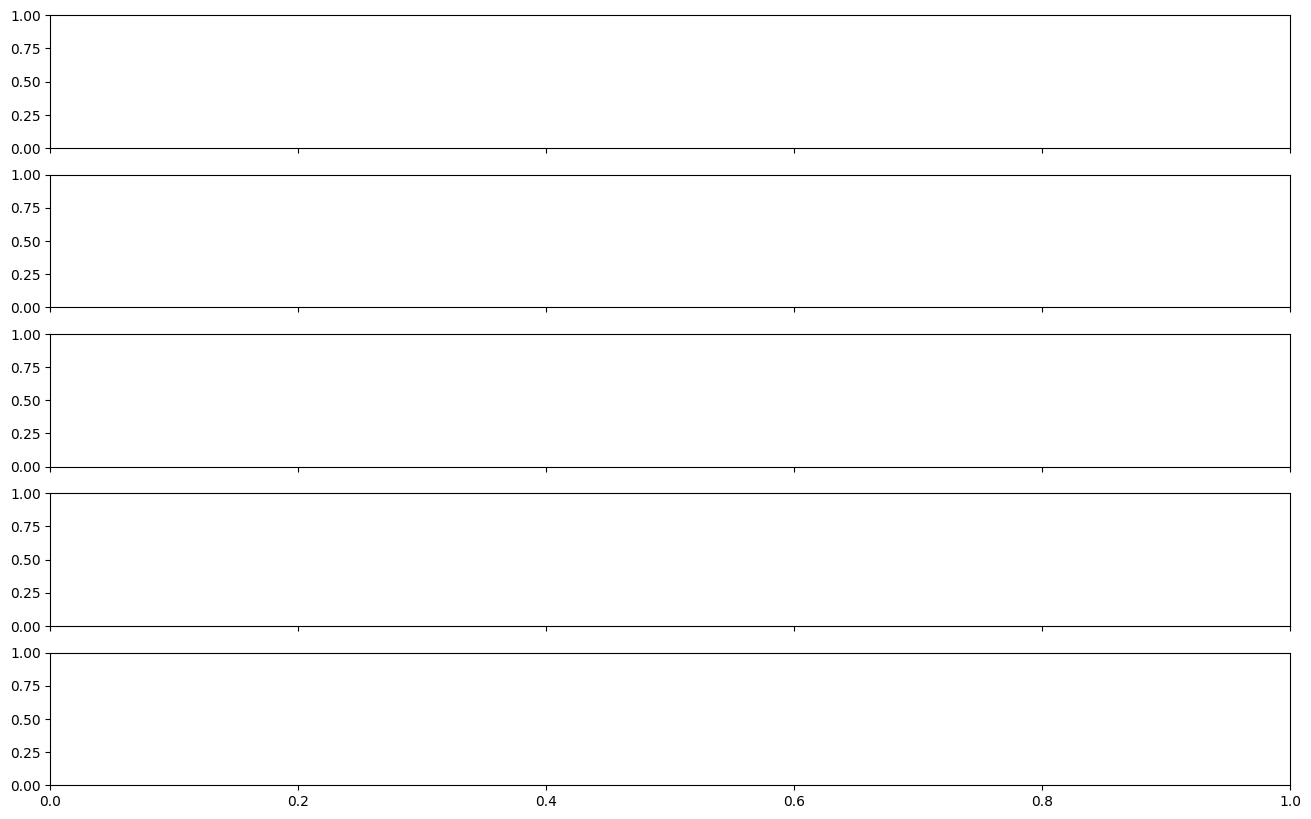

In [ ]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(16, 10))  # , sharey=True)
t = 0

axs[0].plot(df.loc[t, 'EC.forecast.P_resid_ec'], label='EC.P_res', drawstyle='steps-post', color='green')
axs[0].plot(df.loc[t, 'objective.P_el_future'], label='P_res', drawstyle='steps-post', color='red')
axs[0].legend(loc='upper left')
axs[0].set_ylabel('P in W')

axs[1].plot(df.loc[t, 'bes.P_el_future'], label='P_el_of_bes', drawstyle='steps-post', color='red')
axs[1].legend(loc='upper left')
axs[1].set_ylabel('P in W')
twinx_1 = axs[1].twinx()
twinx_1.plot(df.loc[t, 'bes.E_future'], label='E_bes')  # , drawstyle='steps-post')
twinx_1.legend(loc='upper right')
twinx_1.set_ylabel('E in Wh')


axs[2].plot(df.loc[t, 'dhwh1.T_tes_future'], label='T_tes_of_dhwh1_future', color='green') # , drawstyle='steps-post'
axs[2].legend(loc='upper left')
axs[2].set_ylabel('T in °C')

axs[3].plot(df.loc[t, 'dhwh1.forecast.dot_m_demand'], label='dot_m_demand_of_dhwh1', drawstyle='steps-post', color='green')
axs[3].legend(loc='upper left')
axs[3].set_ylabel('dot_m in kg/s')

twinx_2 = axs[3].twinx()
twinx_2.plot(df.loc[t, 'dhwh1.on_future'], label='dhwh1_on', drawstyle='steps-post', color='red')
twinx_2.legend(loc='upper right')
twinx_2.set_ylabel('ON')

axs[4].plot(df.loc[t, 'dhwh1.slack_future'], label='slack_future', drawstyle='steps-post', color='green')
axs[4].legend(loc='upper left')
axs[4].set_ylabel('P in W')


axs[-1].set_xlabel('time in 15 min')

# Current Version

In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cProfile
from models.mp_controller.mp_controller import MPController
from models.mp_controller.opt_models.battery_storage import BES_MILP_model
from models.mp_controller.opt_models.dhwh import DHW_MILP_model_T_m_slack
from models.mp_controller.opt_models.objective import Objective
from models.mp_controller.opt_models.energy_community import EC__Residual_Load_MILP_model

In [2]:
class RandomForecastingMock():
    def __init__(self, inputs, bounds=(0, 1), set_to_zero=None):
        self.inputs = inputs
        self.bounds = bounds
        if not set_to_zero:
            self.set_to_zero = bounds[0]
        else:
            self.set_to_zero = set_to_zero
        self.n = 1

    def get_forcast(self, time) -> list:
        forecast = self.bounds[0] + np.random.random(self.n) * (self.bounds[1] - self.bounds[0])
        forecast[forecast < self.set_to_zero] = 0
        return forecast.tolist()

    def set_data(self, time):
        pass
    
    def set_forcast_length(self, n):
        self.n = n

In [3]:
mp_contr = MPController(name='MPC', n_periods=96, delta_t=60*15, pyo_solver_name='appsi_highs')

objective = Objective('objective', objective='self-consumption-slack')
mp_contr.add_model(objective)

milp_ec  = EC__Residual_Load_MILP_model()
mp_contr.add_model(milp_ec)

ec_forcast = RandomForecastingMock([], (-100, 100))
mp_contr.add_forcaster(ec_forcast, milp_ec, 'P_resid_ec')


milp_bes = BES_MILP_model(
    name='bes',
    E_min=0,
    E_max=20_000*3600, # J
    P_max_cha=2000, # W
    P_max_dis=2000, # W
    eta_cha=0.9, # 
    eta_dis=0.9 # 
    )
mp_contr.add_model(milp_bes)


# milp_dhwh1 = DHW_MILP_model_Temp(name='dhwh1')
milp_dhwh1 = DHW_MILP_model_T_m_slack(name='dhwh1', slack_scale=1/1000)
mp_contr.add_model(milp_dhwh1)

dhwh1_forcast = RandomForecastingMock([], (0, 1/60), 0.5/60)
# mp_contr.add_forcaster(dhwh1_forcast, milp_dhwh1, 'dot_Q_demand')
mp_contr.add_forcaster(dhwh1_forcast, milp_dhwh1, 'dot_m_demand')


check = False

# Gurobi
mp_contr.solver.options['MIPGap'] = 0.01
mp_contr.solver.options['TimeLimit'] = 10
# Highs
mp_contr.solver.options['time_limit'] = 10
mp_contr.solver.options['mip_rel_gap'] = 0.01

# mp_contr.solver.update_config.check_for_new_or_removed_constraints = check
# mp_contr.solver.update_config.check_for_new_or_removed_vars = check
# mp_contr.solver.update_config.update_constraints = check
# mp_contr.solver.update_config.update_vars = check

out = {}
l = 3
for t in range(l):
    print(f'{t} / {l}', end='\r')
    inp = {'bes.E_BES_0':float(np.random.random(1)[0]) *1_000, 'dhwh1.T_tes_0': 30}  #  + float(np.random.random(1)[0])*10}
    out[t] = mp_contr.step(t, **inp)
    out[t].update(inp)

2 RangeSet Declarations
    periods : Dimen=1, Size=96, Bounds=(0, 95)
        Key  : Finite : Members
        None :   True :  [0:95]
    timepoints : Dimen=1, Size=97, Bounds=(0, 96)
        Key  : Finite : Members
        None :   True :  [0:96]

1 Param Declarations
    delta_t : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   900

2 Expression Declarations
    sum_expr_P_el : Size=96, Index=periods
        Key : Expression
          0 : objective.P_el[0] + EC.P_el[0] + bes.P_el[0] + dhwh1.P_el[0]
          1 : objective.P_el[1] + EC.P_el[1] + bes.P_el[1] + dhwh1.P_el[1]
          2 : objective.P_el[2] + EC.P_el[2] + bes.P_el[2] + dhwh1.P_el[2]
          3 : objective.P_el[3] + EC.P_el[3] + bes.P_el[3] + dhwh1.P_el[3]
          4 : objective.P_el[4] + EC.P_el[4] + bes.P_el[4] + dhwh1.P_el[4]
          5 : objective.P_el[5] + EC.P_el[5] + bes.P_el[5] + dhwh1.P_el[5]
          6 : objective.P_el[6] + EC.P_el[6] + bes.P_el[6] + dhwh1.P